In [2]:
%matplotlib inline
from matplotlib import pyplot as pt
import pandas as pd

import os
import glob

/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data/*.txt')
    # sort the files (by date stamp)
    all_files = sorted(glob.glob(csv_path))
    
    print 'reading data from files:'
    for f in all_files:
        print f
    print 'IMPORTANT NOTE: files in the folder must be consecutive! It is up to you to make sure there are not gaps.'
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
data.head()

reading data from files:
/home/ian/metis/team_benson/data/turnstile_160326.txt
/home/ian/metis/team_benson/data/turnstile_160402.txt
IMPORTANT NOTE: files in the folder must be consecutive! It is up to you to make sure there are not gaps.

got 387100 rows total.


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,00:00:00,REGULAR,5590801,1889027
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,04:00:00,REGULAR,5590828,1889032
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,08:00:00,REGULAR,5590852,1889059
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,12:00:00,REGULAR,5590958,1889162
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,16:00:00,REGULAR,5591207,1889248


In [4]:
# How many stations are there?
unique_stations = data.STATION.unique()
print len(unique_stations)

373


In [5]:
# make a datetime column
data['DATETIME'] = pd.to_datetime((data.DATE + ' ' + data.TIME), format="%m/%d/%Y %H:%M:%S")
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,00:00:00,REGULAR,5590801,1889027,2016-03-19 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,04:00:00,REGULAR,5590828,1889032,2016-03-19 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,08:00:00,REGULAR,5590852,1889059,2016-03-19 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,12:00:00,REGULAR,5590958,1889162,2016-03-19 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/19/2016,16:00:00,REGULAR,5591207,1889248,2016-03-19 16:00:00


In [6]:
# Sort data by DATETIME
# data.sort_values(by='DATETIME', inplace=True)
# data.head()

In [21]:
# Group by turnstile
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])

for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)

    #     print turnstile_groupby[diff_field].diff()

In [22]:
# sanity check for getting the differences:
nan_entries = len(data[data.ENTRIES_DIFF.isnull()])
total_unique_turnstiles = len(turnstile_groupby)
print 'the number of NaN entries should equal the total unique turnstiles.'
print nan_entries, total_unique_turnstiles

assert nan_entries == total_unique_turnstiles

the number of NaN entries should equal the total unique turnstiles.
4595 4595


## TODO
* Remove stations with negative ENTRIES_DIFF's


In [68]:
print 'negative entries:'
print len(data[(data.ENTRIES_DIFF < 0)])
# or is this the right way to do it? Watch out for NaN's
print len(data[~(data.ENTRIES_DIFF >= 0)])

negative entries:
2672
7267


## Next, get the total station counts
To do this, groupby station and datetime, and sum the diffs across turnstiles

In [79]:
# group by station name and datetime,
station_time_groupby = data.groupby(['STATION','DATETIME','DATE'], as_index=False)

station_period_totals = station_time_groupby[['ENTRIES_DIFF', 'EXITS_DIFF']].sum()

def remove_suffix(col_name):
    first_underscore = col_name.find('_')
    if first_underscore != -1:
        return col_name[:first_underscore]
    return col_name

# rename the columns, dropping everything after and including the first underscore
station_period_totals.columns = [remove_suffix(column) for column in station_period_totals.columns]

# drop NaN
station_period_totals.dropna(inplace=True)
station_period_totals.head()

,STATION,DATETIME,DATE,ENTRIES,EXITS
1,1 AV,2016-03-19 04:00:00,03/19/2016,1909,801
2,1 AV,2016-03-19 08:00:00,03/19/2016,570,777
3,1 AV,2016-03-19 12:00:00,03/19/2016,2488,1972
4,1 AV,2016-03-19 16:00:00,03/19/2016,4229,2511
5,1 AV,2016-03-19 20:00:00,03/19/2016,4453,2821


In [95]:
daily_station_totals = station_period_totals.drop('DATETIME', axis=1).groupby(['STATION','DATE'], as_index=False).sum()
daily_station_totals.head()

,STATION,DATE,ENTRIES,EXITS
0,1 AV,03/19/2016,13649,8882
1,1 AV,03/20/2016,13986,9515
2,1 AV,03/21/2016,22018,13959
3,1 AV,03/22/2016,23910,14769
4,1 AV,03/23/2016,24688,14857


In [101]:
# find top stations for ENTRIES on date of interest
date_of_interest = '03/19/2016'
top_daily_entries = daily_station_totals[daily_station_totals['DATE'] == date_of_interest].sort_values(by='ENTRIES', ascending=False).head(10)
top_daily_entries

,STATION,DATE,ENTRIES,EXITS
196,14 ST-UNION SQ,03/19/2016,75948,70351
854,34 ST-PENN STA,03/19/2016,75752,70936
1526,86 ST,03/19/2016,59443,51300
826,34 ST-HERALD SQ,03/19/2016,54401,57732
644,23 ST,03/19/2016,52385,46559
3199,GRD CNTRL-42 ST,03/19/2016,49061,47408
4860,TIMES SQ-42 ST,03/19/2016,47719,62906
952,42 ST-PORT AUTH,03/19/2016,46458,41707
2364,CANAL ST,03/19/2016,44311,36121
126,125 ST,03/19/2016,41292,38407


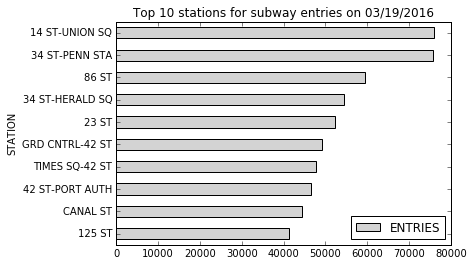

In [124]:
# for some reason you have to make ascending=True to make barh in descending order...
top_daily_entries.sort_values(by='ENTRIES', ascending=True).plot.barh(x='STATION', 
    y='ENTRIES', 
    title='Top 10 stations for subway entries on %s' % date_of_interest,
    color='lightgrey',
    legend=True)

# TODO
* Do that same graph, but for the month that Lucia did

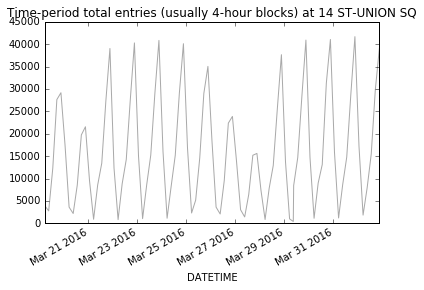

In [137]:
station_of_interest = '14 ST-UNION SQ'
station_period_totals[station_period_totals['STATION'] == station_of_interest][['DATETIME','ENTRIES']].plot(
    title='Time-period total entries (usually 4-hour blocks) at %s' % station_of_interest,
    x='DATETIME',
    y='ENTRIES',
    legend=False,
    color='darkgrey')